# Préparation des livrables

Dans ce dernier notebook on va synthétiser tous nos résultats en prépant de livrables.

On souhaite faire :

- un dossier avec toutes les décisions que l'on a etudié

- un tableau excel pour pouvoir y accéder plus facilement.

- un graphique qui représente une sorte "d'arbres de décisions"



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil  # pour copier des fichiers

## 1. Tableau google sheet

On veut faire un tableau qui présente synthétiquement nos résultats et permet d'y accéder facilement.

In [2]:
# lecture des données
df = pd.read_csv("../data/intermediate_data.csv")

# on affiche toutes les colonnes que l'on a créé 
# pour pouvoir choisir celles qui nous intéressent
print(df.columns)

Index(['path', 'new_path', 'ordonnance_de_renvoi', 'instance', 'year', 'month',
       'id', 'majoration', 'type_recours', 'test_sentence_1', 'sentence_1',
       'test_sentence_2', 'sentence_2', 'personne_1', 'match_1', 'personne_2',
       'match_2', 'personne_synthetic', 'décision', 'code_juridiction',
       'nom_juridiction'],
      dtype='object')


On ne garde que les colonnes que l'on souhaite

In [3]:
desired_columns = ['path','instance', 'year', 'month',
       'id', 'majoration', 'type_recours', 'personne_synthetic', 'décision', 'code_juridiction',
       'nom_juridiction']

# on filtre les colonnes
df = df[desired_columns]

# on donne de nouveaux noms aux colonnes pour être plus lisisbles
new_names = ["Chemin",'Instance déliberatrice',"Année",'Mois',"Identifiant",'Majoration','Type recours',"Personnalité","Décision","Code juridiction","Nom juridiction"]

# on affecte ces nouveaux noms de colonnes
df.columns = new_names

# on affiche les 5 premières lignes du tableau
df.head()

,Chemin,Instance déliberatrice,Année,Mois,Identifiant,Majoration,Type recours,Personnalité,Décision,Code juridiction,Nom juridiction
0,../data/raw/DTA/2022/11/TA38/DTA_2002498_20221...,TA,2022,11,2002498,40%,Plein contentieux,P.P.,Satisfaction partielle,38,Tribunal Administratif de Grenoble
1,../data/raw/DTA/2022/11/TA38/DTA_2006107_20221...,TA,2022,11,2006107,40%,Plein contentieux,P.M.,Rejet,38,Tribunal Administratif de Grenoble
2,../data/raw/DTA/2022/11/TA38/DTA_1905044_20221...,TA,2022,11,1905044,40%,Plein contentieux,P.P.,Rejet,38,Tribunal Administratif de Grenoble
3,../data/raw/DTA/2022/11/TA38/DTA_1905713_20221...,TA,2022,11,1905713,40%,Plein contentieux,P.M.,Satisfaction partielle,38,Tribunal Administratif de Grenoble
4,../data/raw/DTA/2022/11/TA63/DTA_1902047_20221...,TA,2022,11,1902047,40%,Plein contentieux,P.M.,Rejet,63,Tribunal Administratif de Clermont-Ferrand


On va maintenant simplifier au maximum les intitulés pour que ce soit le plus lisible possible.

In [4]:
# on change les valeurs de la colonen "Instance déliberatrice"
df["Instance déliberatrice"] = df["Instance déliberatrice"].replace("TA","Tribunal administratif")
df["Instance déliberatrice"] = df["Instance déliberatrice"].replace("CAA","Cour administrative d'appel")

In [5]:
# on créée une colonne date pour remplacer les colonnes Année et Mois
df["Date"] = df["Année"].astype(str) + "-" + df["Mois"].astype(str)

# on supprime les colonnes Année et Mois
df = df.drop(columns=["Année","Mois"])

In [6]:
# on remplace les valeurs de la colonne Personnalité
df["Personnalité"] = df["Personnalité"].replace("P.P.","Personne physique").replace("P.M.","Personne morale")


In [7]:
# les noms des types recours ne sont pas harmonisés
# on va les harmoniser en mettant une majuscule à chaque début de mot
df["Type recours"] = df["Type recours"].str.title()

Il y a aussi beaucoup de type de décisions différentes, pour simplifier on va les regrouper en grandes catégories.

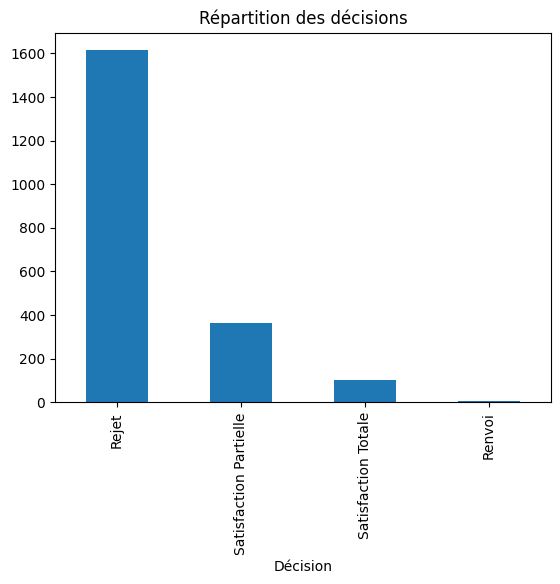

In [8]:
# catégorisation des décisions telles quelles
old_cat = ['Satisfaction partielle',
 'Rejet',
 'Satisfaction totale',
 'Non-lieu',
 'Désistement',
 'Renvoi',
 'ADD - Expertise / Médiation',
 'Avis article L.113-1',
 'Radiation des registres']

# nouvelle catégorisation des décisions
# l'element 1 de la liste correspond à l'élément 1 de la liste old_cat
# et ainsi de suite
new_cat = ['Satisfaction Partielle',
           'Rejet',
              'Satisfaction Totale',
              'Rejet',
              'Rejet',
              'Renvoi',
              'Renvoi',
              'Renvoi',
              'Rejet']

# on remplace les valeurs de la colonne Décision
df["Décision"] = df["Décision"].replace(old_cat,new_cat)

# on fait un graphique pour voir la répartition des décisions
# et on le sauvegarde
df["Décision"].value_counts().plot(kind="bar").set_title("Répartition des décisions").figure.savefig("../output/répartitions_des_décisions_nouvelles_catégories.png")


Enfin pour pouvoir faire un excel propre, on a envire de pouvoir accéder à chaque décision depuis un navigateur (Chrome,Brave ...).

Pour cela, on va tirer parti de la fonction hyperlink de sheets et de l'hébergement de nos données sur Github.

On créera l'excel à la main à partir du dataframe.

In [14]:
# base de l'url du repository Github
url = "https://raw.githubusercontent.com/78jeanlebret/legal_data_analysis/main/data/final/"


# pour voir un document en particulier,
# il faut ajouter le chemin qui mène à ce dossier
# ex : https://raw.githubusercontent.com/78jeanlebret/legal_data_analysis/main/data/final/DCA/2023/01/doc.xml

# fonction qui renvoie l'url complète vers un fichier
def construct_url(path):

    # on rajoute le chemin vers le fichier
    # ex : DCA/2022/01/doc.xml
    id = path.split("raw/")[1]
    return url + id

# on applique la fonction à chaque ligne du tableau
df["Lien fichier"] = df.Chemin.apply(construct_url)

On peut maintenant sauvegarder notre tableau.

In [15]:
df.to_csv("../data/final_data.csv",index=False)

## 2. Dossier avec toutes les données

Jusqu'à présent, on avait en local toutes les décisions des TA et des CAA en local sur notre ordinateur, ou partagées via un Drive.

Pour pouvoir les télécharger sur Github en réduisant l'énergie nécessaire au stockage et au transfert, et pour pouvoir les retravailler si besoin, on va créer un nouveau dossier avec uniquement les décisions intéressantes.

In [52]:
# création d'un nouveau dossier
os.makedirs("../data/final",exist_ok=True)

# on crée un nouveau chemin d'accès pour chaque fichier
# en remplacant data/raw par data/final
df["Chemin final"]= df["Chemin"].str.replace("data/raw","data/final")

# on copie chaque fichier dans le nouveau dossier
# pour chaque ligne du tableau
for index,row in df.iterrows():

    # on crée le dossier si il n'existe pas
    os.makedirs("/".join(row["Chemin final"].split("/")[:-1]),exist_ok=True)

    # on copie le fichier
    shutil.copy(row["Chemin"],row["Chemin final"])

## 3. Graphique

On cherche à faire le graphique qui présente le plus synthétiquement nos résultats.

Pour des questions de temps, on éditera le graphique sur power point et les statistiques sur le Excel que l'on a fait.